In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import time
import dask.bag as db
import dask.diagnostics as dd
import random
from termcolor import colored
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2M, EfficientNetV2B0, EfficientNetV2B3, Xception, ResNet50
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score

2024-11-19 15:41:49.008253: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
!nvidia-smi

Tue Nov 19 15:41:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:4E:00.0 Off |                   On |
| N/A   28C    P0             49W /  400W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [3]:
CWD = os.getcwd()
CWD

'/workspace'

In [4]:
EPOCHS = 30
SAVE_DIRECTORY = CWD + '/model'

# Load Data

In [5]:
BASE_DIR = os.path.join(CWD, 'dataset', 'processed', 'Training')
TEST_DIR = os.path.join(CWD, 'dataset', 'processed', 'Testing')
CLASS_DIR = os.path.join(CWD, 'train_224', 'Training')

In [6]:
# Loop over folders to extract class_names
classes = [class_name for class_name in os.listdir(CLASS_DIR) if os.path.isdir(os.path.join(CLASS_DIR, class_name)) and not class_name.startswith('.')]
classes

['glioma', 'meningioma', 'pituitary', 'notumor']

In [7]:
def prepare_dataset(BASE_DIR, IMG_SIZE, batch_size):
    train_full = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,        
        labels='inferred',         
        label_mode='categorical',  
        class_names=classes,       
        seed=42,                   
        batch_size=batch_size,             
        image_size=(IMG_SIZE, IMG_SIZE)      
    )

    train_full = train_full.prefetch(tf.data.AUTOTUNE)
    
    # Counting number of all batches in dataset
    num_of_full_train_batches = len(list(train_full))
    print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'red', attrs=['bold']))
    
    # Define variable to store number of batches for train dataset
    num_train_batches = int(num_of_full_train_batches * 0.70)
    
    # Define variable to store number of batches for validation and test dataset
    num_valid_test_batches = num_of_full_train_batches - num_train_batches
    
    # Print the TARGET : number of batches for train, validation and test dataset to each
    print(colored(' Target : ', 'green', attrs=['bold']))
    print('-'*35)
    print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
    print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
    print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

    # Apply above settings to main dataset to split to train, validation and test dataset
    train_ds = train_full.take(num_train_batches)
    remain_ds = train_full.skip(num_train_batches)
    valid_ds = remain_ds.take(num_valid_test_batches)

    train_ds = train_ds.shuffle(buffer_size=3)
    

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        labels='inferred',
        label_mode = 'categorical',
        class_names=classes,
        seed=42,
        batch_size=batch_size,
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    return train_ds, valid_ds, test_ds

In [8]:
def prepare_dataset(BASE_DIR, TEST_DIR, IMG_SIZE, batch_size):
    train_full = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,        
        labels='inferred',         
        label_mode='categorical',  
        class_names=classes,       
        seed=42,                   
        batch_size=batch_size,             
        image_size=(IMG_SIZE, IMG_SIZE)      
    )

    train_full = train_full.prefetch(tf.data.AUTOTUNE)
    
    # Counting number of all batches in dataset
    num_of_full_train_batches = len(list(train_full))
    print(colored(f'Number of batches in train_full : {num_of_full_train_batches}', 'red', attrs=['bold']))
    
    # Define variable to store number of batches for train dataset
    num_train_batches = int(num_of_full_train_batches * 0.70)
    
    # Define variable to store number of batches for validation and test dataset
    num_valid_test_batches = num_of_full_train_batches - num_train_batches
    
    # Print the TARGET : number of batches for train, validation and test dataset to each
    print(colored(' Target : ', 'green', attrs=['bold']))
    print('-'*35)
    print(colored(f'Number of  Train  batches : {num_train_batches}', 'blue', attrs=['bold']))
    print(colored(f'Number of Validation batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))
    print(colored(f'Number of Test batches : {num_valid_test_batches//2}', 'blue', attrs=['bold']))

    # Apply above settings to main dataset to split to train, validation and test dataset
    train_ds = train_full.take(num_train_batches)
    valid_ds = train_full.take(num_valid_test_batches)

    train_ds = train_ds.shuffle(buffer_size=3)
    

    test_ds = tf.keras.utils.image_dataset_from_directory(
        directory=TEST_DIR,
        labels='inferred',
        label_mode = 'categorical',
        class_names=classes,
        seed=42,
        batch_size=batch_size,
        image_size=(IMG_SIZE, IMG_SIZE)
    )

    return train_ds, valid_ds, test_ds

In [9]:
def build_model_trainable_last25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze first 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:(int(0.75 * total_layers))]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model    

In [10]:
def build_model_trainable_first25(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = True

    # Freeze last 75% layers
    total_layers = len(base_model.layers)
    for layer in base_model.layers[(int(0.75 * total_layers)):]:
        layer.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model  

In [11]:
def build_model_not_trainable(base_model, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False

    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    return model

In [12]:
def train(model, model_name, train_ds, valid_ds, epochs, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    saving_path = os.path.join(save_directory, f'model_{model_name}.h5')

    # Model CheckPoint Call-Back, to save best model parameters as a .keras file
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    #earlystop_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    start = time.time()

    # Model training
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data = valid_ds,
        callbacks=[checkpoint_cb, reduce_lr]
    )

    end = time.time()

    # Counting trianing time
    training_time = end - start
    print(f"Training completed in {training_time:.2f} seconds.")

    return model, history, training_time

In [13]:
def best_variant(model_name_1, model_1, history_1, time_1,
                 model_name_2, model_2, history_2, time_2,
                 model_name_3, model_3, history_3, time_3,
                 test_ds, output_csv, output_folder='results'):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Evaluate each model and collect results
    models_info = []

    for model_name, model, history, time in [
        (model_name_1, model_1, history_1, time_1),
        (model_name_2, model_2, history_2, time_2),
        (model_name_3, model_3, history_3, time_3)
    ]:
        # Assume val_accuracy as a proxy for F1 score
        val_f1score = max(history.history['val_accuracy'])
        val_loss = min(history.history['val_loss'])
        val_acc = max(history.history['val_accuracy'])

        # Store each model's information in models_info
        models_info.append({
            'Model Name': model_name,
            'Model': model,
            'Loss': val_loss,
            'Accuracy': val_acc,
            'F1 Score': val_f1score,
            'Training Time': time,
            'History': history
        })

    # Sort the models by F1 Score in descending order
    models_info = sorted(models_info, key=lambda x: x['F1 Score'], reverse=True)

    # Convert to DataFrame for a neat tabular display
    df = pd.DataFrame([{k: v for k, v in m.items() if k != 'Model' and k != 'History'} for m in models_info])
    
    # Save to CSV
    output_path = os.path.join(output_folder, output_csv)
    df.to_csv(output_path, index=False)
    print(f"Model comparison table saved to {output_csv}")
          
    # Print DataFrame
    print("Model Comparison Table:")
    print(df)

    # Select the best model based on F1 Score
    best_model_info = models_info[0]
    best_model = best_model_info['Model']
    best_model_name = best_model_info['Model Name']
    best_history = best_model_info['History']
    best_time = best_model_info['Training Time']

    # Evaluate on the test dataset using plot function
    best_history, test_loss, test_acc, test_f1score = plot(best_model, best_history, test_ds)

    # Return the best model's evaluation results for updating result_dict later
    return best_model_name, test_loss, test_acc, test_f1score, best_time

In [14]:
def plot(model, history, test_ds):
    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2)
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2)
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return history, test_loss, test_acc, test_f1score


In [15]:
def save_results_to_csv(result_dict, file_path='results/results.csv'):
    # Convert result_dict to DataFrame
    df = pd.DataFrame(result_dict)
    
    # If the file exists, append to it; otherwise, create a new file
    if os.path.exists(file_path):
        existing_df = pd.read_csv(file_path)
        df = pd.concat([existing_df, df], ignore_index=True)
    
    # Save the combined DataFrame to CSV
    df.to_csv(file_path, index=False)
    print(f"Results saved to {file_path}")

# Function to load results from a CSV file
def load_results_from_csv(file_path='results/mresult.csv'):
    # If the file exists, load it; otherwise, return an empty dictionary
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        result_dict =  df.to_dict(orient='list')
    else:
        result_dict =  {
            'Model Name': [],
            'Test Loss': [],
            'Test Accuracy': [],
            'Test F1Score': [],
            'Training Time': []
        }
    return result_dict

In [16]:
def result(model_name, test_loss, test_acc, test_f1score, result_dict, training_time):
    
    test_f1score = test_f1score[1] if isinstance(test_f1score, (list, np.ndarray)) else test_f1score
    
    result_dict['Model Name'].append(model_name)
    result_dict['Test Loss'].append(test_loss)
    result_dict['Test Accuracy'].append(test_acc)
    result_dict['Test F1Score'].append(test_f1score)
    result_dict['Training Time'].append(training_time)
    
    save_results_to_csv(result_dict, 'results/result.csv')

result_dict = {
    'Model Name': [],
    'Test Loss': [],
    'Test Accuracy': [],
    'Test F1Score': [],
    'Training Time': []
}

# Prepare training dataset

In [17]:
train_dir_224 = "train_224/Training"
test_dir_224 = "train_224/Testing"

train_dir_300 = "train_300/Training"
test_dir_300= "train_300/Testing"

train_dir_480 = "train_480/Training"
test_dir_480 = "train_480/Testing"

In [18]:
train_ds_224, valid_ds_224, test_ds_224 = prepare_dataset(train_dir_224, test_dir_224, 224, 32)
train_ds_300, valid_ds_300, test_ds_300 = prepare_dataset(train_dir_224, test_dir_224, 300, 16)
train_ds_480, valid_ds_480, test_ds_480 = prepare_dataset(train_dir_224, test_dir_224, 480, 2)

Found 5712 files belonging to 4 classes.


2024-11-19 15:42:16.402001: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17947 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:4e:00.0, compute capability: 8.0


Number of batches in train_full : 179
 Target : 
-----------------------------------
Number of  Train  batches : 125
Number of Validation batches : 27
Number of Test batches : 27
Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.
Number of batches in train_full : 357
 Target : 
-----------------------------------
Number of  Train  batches : 249
Number of Validation batches : 54
Number of Test batches : 54
Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.
Number of batches in train_full : 2856
 Target : 
-----------------------------------
Number of  Train  batches : 1999
Number of Validation batches : 428
Number of Test batches : 428
Found 1311 files belonging to 4 classes.


# Model Training

## Standard

### EfficientNetV2B0

#### trainable first25

In [20]:
model_name_1 = 'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer'
input_shape = (224,224,3)

std_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tf25, history_std_b0_tf25, training_time_1 = train(std_b0_tf25, model_name_1, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 09:48:08.896392: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-17 09:48:10.773793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-11-17 09:48:11.093001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-17 09:48:11.323674: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1a0869ae10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-17 09:48:11.323722: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2024-11-17 09:48:11.359263: I tensorflow/compiler/mlir/tensorflow/utils/dump_ml

125/125 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.7445 - f1_score: 0.7383

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 42s 102ms/step - loss: 0.6802 - accuracy: 0.7445 - f1_score: 0.7383 - val_loss: 0.3507 - val_accuracy: 0.8791 - val_f1_score: 0.8767 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 9s 70ms/step - loss: 0.2487 - accuracy: 0.9135 - f1_score: 0.9117 - val_loss: 0.1261 - val_accuracy: 0.9537 - val_f1_score: 0.9528 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 9s 69ms/step - loss: 0.1199 - accuracy: 0.9590 - f1_score: 0.9579 - val_loss: 0.0768 - val_accuracy: 0.9728 - val_f1_score: 0.9724 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 8s 65ms/step - loss: 0.0902 - accuracy: 0.9678 - f1_score: 0.9669 - val_loss: 0.0926 - val_accuracy: 0.9705 - val_f1_score: 0.9698 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 9s 69ms/step - loss: 0.0385 - accuracy: 0.9895 - f1_score: 0.9892 - val_loss: 0.0121 - val_accuracy: 0.9954 - val_f1_score: 0.9953 - lr: 1.0000e-04

#### trainable last25

In [21]:
model_name_2 = 'EfficientnetV2B0 Without Augmentation Trainable Last 25 Layer'
input_shape = (224,224,3)

std_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_tl25, history_std_b0_tl25, training_time_2 = train(std_b0_tl25, model_name_2, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 09:52:52.138030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 18s 51ms/step - loss: 0.6539 - accuracy: 0.7335 - f1_score: 0.7265 - val_loss: 0.2708 - val_accuracy: 0.8970 - val_f1_score: 0.8943 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 5s 38ms/step - loss: 0.2546 - accuracy: 0.9053 - f1_score: 0.9027 - val_loss: 0.1531 - val_accuracy: 0.9433 - val_f1_score: 0.9421 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 5s 38ms/step - loss: 0.1452 - accuracy: 0.9463 - f1_score: 0.9448 - val_loss: 0.0842 - val_accuracy: 0.9699 - val_f1_score: 0.9694 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 5s 40ms/step - loss: 0.0865 - accuracy: 0.9710 - f1_score: 0.9701 - val_loss: 0.0662 - val_accuracy: 0.9786 - val_f1_score: 0.9780 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 5s 39ms/step - loss: 0.0564 - accuracy: 0.9793 - f1_score: 0.9785 - val_loss: 0.0254 - val_accuracy: 0.9925 - val_f1_score: 0.9923 - lr: 1.0000e-04


#### not trainable

In [22]:
model_name_3 = 'EfficientnetV2B0 Without Augmentation Not Trainable'
input_shape = (224,224,3)

std_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
std_b0_nt, history_std_b0_nt, training_time_3 = train(std_b0_nt, model_name_3, train_ds_224, valid_ds_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30
125/125 [==============================] - 10s 41ms/step - loss: 1.0167 - accuracy: 0.5805 - f1_score: 0.5662 - val_loss: 0.6152 - val_accuracy: 0.7876 - val_f1_score: 0.7668 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - 4s 32ms/step - loss: 0.6012 - accuracy: 0.7788 - f1_score: 0.7698 - val_loss: 0.4162 - val_accuracy: 0.8501 - val_f1_score: 0.8410 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - 4s 32ms/step - loss: 0.4603 - accuracy: 0.8305 - f1_score: 0.8241 - val_loss: 0.3466 - val_accuracy: 0.8704 - val_f1_score: 0.8639 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - 4s 31ms/step - loss: 0.3973 - accuracy: 0.8562 - f1_score: 0.8512 - val_loss: 0.3033 - val_accuracy: 0.8877 - val_f1_score: 0.8849 - lr: 1.0000e-04
Epoch 5/30
125/125 [==============================] - 4s 35ms/step - loss: 0.3571 - accuracy: 0.8625 - f1_score: 0.8581 - val_loss: 0.2789 - val_accuracy: 0.8976 - val_f1_score: 0.8945 - lr: 

Model comparison table saved to EfficientNetV2B0 Without Agumentation
Model Comparison Table:
                                          Model Name      Loss  Accuracy  \
0  EfficientnetV2B0 Without Augmentation Trainabl...  0.000007  1.000000   
1  EfficientnetV2B0 Without Augmentation Trainabl...  0.000034  1.000000   
2  EfficientnetV2B0 Without Augmentation Not Trai...  0.052285  0.985532   

   F1 Score  Training Time  
0  1.000000     284.886228  
1  1.000000     153.842302  
2  0.985532     127.438671  
1/1 [==============================] - 1s 1s/step


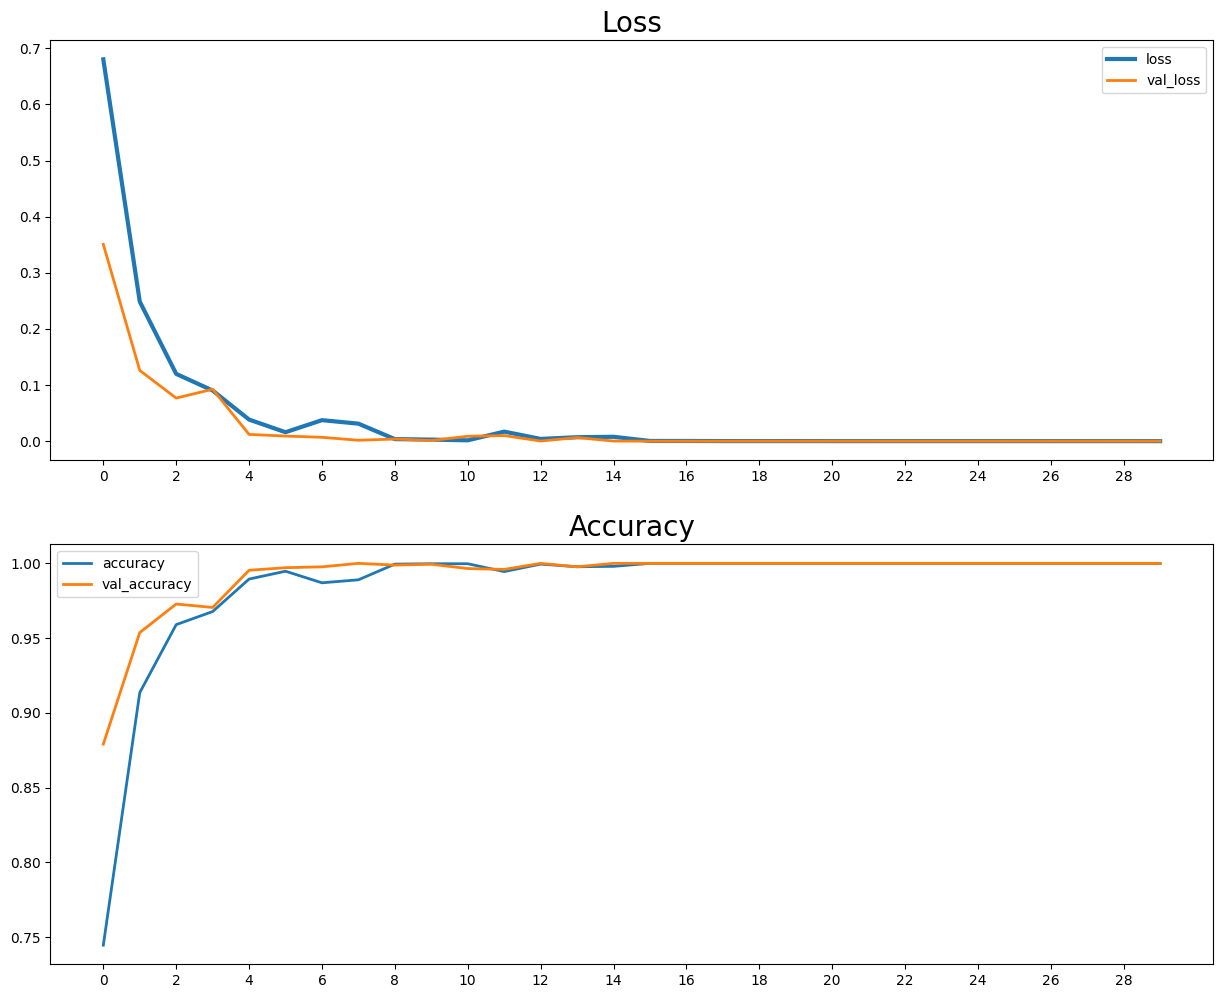

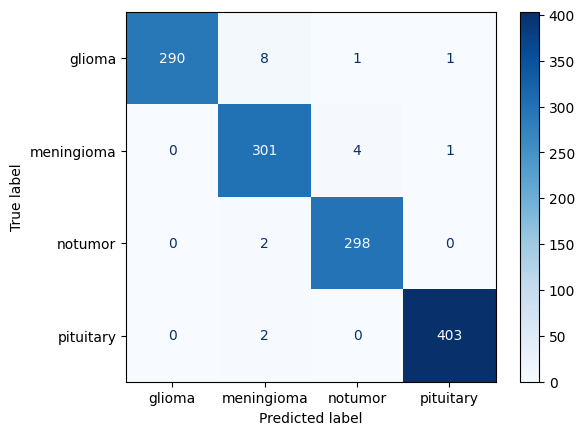

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.96667   0.98305       300
           1    0.96166   0.98366   0.97254       306
           2    0.98350   0.99333   0.98839       300
           3    0.99506   0.99506   0.99506       405

    accuracy                        0.98551      1311
   macro avg    0.98506   0.98468   0.98476      1311
weighted avg    0.98575   0.98551   0.98553      1311



In [23]:
best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
    model_name_1, std_b0_tf25, history_std_b0_tf25, training_time_1,
    model_name_2, std_b0_tl25, history_std_b0_tl25, training_time_2,
    model_name_3, std_b0_nt, history_std_b0_nt, training_time_3,
    test_ds_224, "EfficientNetV2B0 Without Agumentation"
)

In [24]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   

   Test Accuracy  Test F1Score  Training Time  
0       0.985507      0.972536     284.886228  


### EfficientNetV2B3

#### trainable first25

In [25]:
model_name_1 = 'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer'
input_shape = (300,300,3)

std_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tf25, history_std_b3_tf25, training_time_1 = train(std_b3_tf25, model_name_1, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 09:57:56.561459: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - ETA: 0s - loss: 0.5090 - accuracy: 0.8025 - f1_score: 0.7963

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/249 [==============================] - 73s 118ms/step - loss: 0.5090 - accuracy: 0.8025 - f1_score: 0.7963 - val_loss: 0.1628 - val_accuracy: 0.9421 - val_f1_score: 0.9415 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 26s 105ms/step - loss: 0.1595 - accuracy: 0.9445 - f1_score: 0.9432 - val_loss: 0.0515 - val_accuracy: 0.9838 - val_f1_score: 0.9835 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 27s 108ms/step - loss: 0.0848 - accuracy: 0.9726 - f1_score: 0.9720 - val_loss: 0.0504 - val_accuracy: 0.9844 - val_f1_score: 0.9841 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 26s 106ms/step - loss: 0.0496 - accuracy: 0.9844 - f1_score: 0.9840 - val_loss: 0.0269 - val_accuracy: 0.9902 - val_f1_score: 0.9899 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 26s 105ms/step - loss: 0.0239 - accuracy: 0.9930 - f1_score: 0.9928 - val_loss: 0.0110 - val_accuracy: 0.9959 - val_f1_score: 0.9959 - lr: 1.

#### trainable last25

In [26]:
model_name_2 = 'EfficientnetV2B3 Without Augmentation Trainable Last 25% Layer'
input_shape = (300,300,3)

std_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_tl25, history_std_b3_tl25, training_time_2 = train(std_b3_tl25, model_name_2, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 10:11:32.387889: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


249/249 [==============================] - 33s 62ms/step - loss: 0.4791 - accuracy: 0.8225 - f1_score: 0.8167 - val_loss: 0.1685 - val_accuracy: 0.9317 - val_f1_score: 0.9296 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 13s 53ms/step - loss: 0.1576 - accuracy: 0.9478 - f1_score: 0.9461 - val_loss: 0.0655 - val_accuracy: 0.9780 - val_f1_score: 0.9776 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 13s 53ms/step - loss: 0.0598 - accuracy: 0.9787 - f1_score: 0.9779 - val_loss: 0.0382 - val_accuracy: 0.9873 - val_f1_score: 0.9870 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 13s 50ms/step - loss: 0.0511 - accuracy: 0.9834 - f1_score: 0.9829 - val_loss: 0.2571 - val_accuracy: 0.9259 - val_f1_score: 0.9249 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 13s 50ms/step - loss: 0.0356 - accuracy: 0.9885 - f1_score: 0.9882 - val_loss: 0.1824 - val_accuracy: 0.9664 - val_f1_score: 0.9659 - lr: 1.0000e

#### not trainable

In [27]:
model_name_3 = 'EfficientnetV2B3 Without Augmentation Not Trainable'
input_shape = (300,300,3)

std_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
std_b3_nt, history_std_b3_nt, training_time_3 = train(std_b3_nt, model_name_3, train_ds_300, valid_ds_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30
249/249 [==============================] - 20s 51ms/step - loss: 0.7657 - accuracy: 0.7058 - f1_score: 0.6892 - val_loss: 0.4282 - val_accuracy: 0.8432 - val_f1_score: 0.8427 - lr: 1.0000e-04
Epoch 2/30
249/249 [==============================] - 11s 44ms/step - loss: 0.4549 - accuracy: 0.8311 - f1_score: 0.8249 - val_loss: 0.3361 - val_accuracy: 0.8785 - val_f1_score: 0.8781 - lr: 1.0000e-04
Epoch 3/30
249/249 [==============================] - 11s 44ms/step - loss: 0.3626 - accuracy: 0.8655 - f1_score: 0.8615 - val_loss: 0.2762 - val_accuracy: 0.9005 - val_f1_score: 0.8984 - lr: 1.0000e-04
Epoch 4/30
249/249 [==============================] - 11s 44ms/step - loss: 0.3214 - accuracy: 0.8840 - f1_score: 0.8806 - val_loss: 0.2487 - val_accuracy: 0.9057 - val_f1_score: 0.9047 - lr: 1.0000e-04
Epoch 5/30
249/249 [==============================] - 11s 44ms/step - loss: 0.2869 - accuracy: 0.8951 - f1_score: 0.8918 - val_loss: 0.2297 - val_accuracy: 0.9138 - val_f1_score: 0.9130 - 

Model comparison table saved to EfficientNetV2B3 Without Agumentation
Model Comparison Table:
                                          Model Name      Loss  Accuracy  \
0  EfficientnetV2B3 Without Augmentation Trainabl...  0.000009  1.000000   
1  EfficientnetV2B3 Without Augmentation Trainabl...  0.000159  1.000000   
2  EfficientnetV2B3 Without Augmentation Not Trai...  0.020239  0.995949   

   F1 Score  Training Time  
0  1.000000     818.727502  
1  1.000000     409.166996  
2  0.995949     334.765421  
1/1 [==============================] - 0s 69ms/step


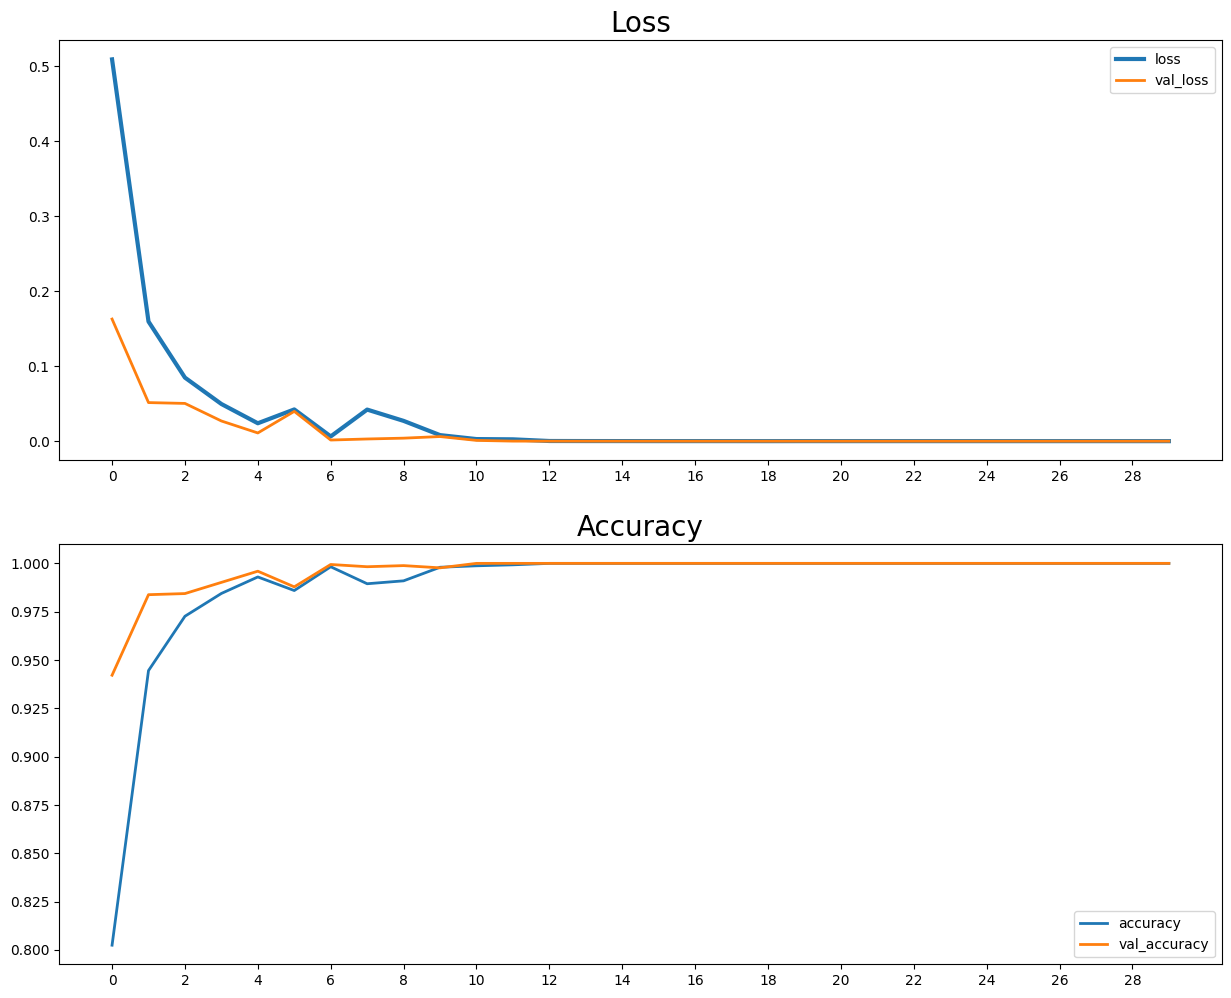

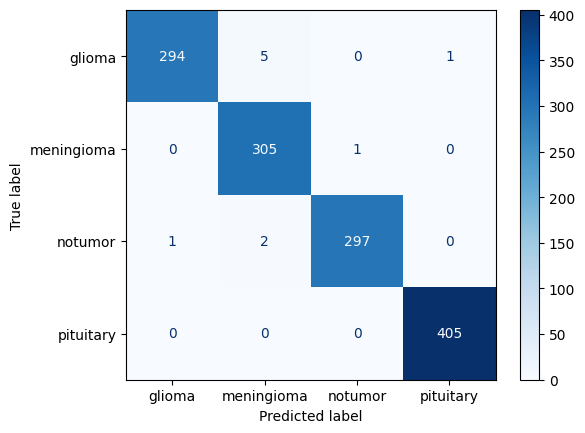

Classification Report
              precision    recall  f1-score   support

           0    0.99661   0.98000   0.98824       300
           1    0.97756   0.99673   0.98706       306
           2    0.99664   0.99000   0.99331       300
           3    0.99754   1.00000   0.99877       405

    accuracy                        0.99237      1311
   macro avg    0.99209   0.99168   0.99184      1311
weighted avg    0.99246   0.99237   0.99237      1311



In [28]:
best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
            model_name_1, std_b3_tf25, history_std_b3_tf25, training_time_1,
             model_name_2, std_b3_tl25, history_std_b3_tl25, training_time_2,
             model_name_3, std_b3_nt, history_std_b3_nt, training_time_3,
             test_ds_300, 'EfficientNetV2B3 Without Agumentation')

In [29]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.053577   

   Test Accuracy  Test F1Score  Training Time  
0       0.985507      0.972536     284.886228  
1       0.992372      0.987055     818.727502  


### EfficientNetV2M

#### trainable first25

In [30]:
model_name_1 = 'EfficientnetV2M Without Augmentation Trainable First 25% Layer'
input_shape = (480,480,3)

std_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tf25, history_std_m_tf25, training_time_1 = train(std_m_tf25, model_name_1, train_ds_480, valid_ds_480, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 10:24:42.702731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


499/499 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.7728 - f1_score: 0.7674

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


499/499 [==============================] - 227s 302ms/step - loss: 0.5836 - accuracy: 0.7728 - f1_score: 0.7674 - val_loss: 0.1695 - val_accuracy: 0.9442 - val_f1_score: 0.9431 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 146s 293ms/step - loss: 0.2063 - accuracy: 0.9344 - f1_score: 0.9331 - val_loss: 0.1690 - val_accuracy: 0.9477 - val_f1_score: 0.9476 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 146s 293ms/step - loss: 0.1286 - accuracy: 0.9607 - f1_score: 0.9603 - val_loss: 0.1499 - val_accuracy: 0.9506 - val_f1_score: 0.9505 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 146s 291ms/step - loss: 0.0741 - accuracy: 0.9800 - f1_score: 0.9797 - val_loss: 0.0446 - val_accuracy: 0.9843 - val_f1_score: 0.9841 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 143s 287ms/step - loss: 0.0612 - accuracy: 0.9810 - f1_score: 0.9806 - val_loss: 0.0601 - val_accuracy: 0.9802 - val_f1_score: 0.9801 - l

#### trainable last25

In [31]:
model_name_2 = 'EfficientnetV2M Without Augmentation Trainable Last 25% Layer'
input_shape = (480,480,3)

std_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_tl25, history_std_m_tl25, training_time_2 = train(std_m_tl25, model_name_2, train_ds_480, valid_ds_480, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 11:37:57.384352: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


499/499 [==============================] - 109s 153ms/step - loss: 0.4755 - accuracy: 0.8216 - f1_score: 0.8171 - val_loss: 0.2377 - val_accuracy: 0.9099 - val_f1_score: 0.9058 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 74s 148ms/step - loss: 0.1653 - accuracy: 0.9459 - f1_score: 0.9444 - val_loss: 0.1595 - val_accuracy: 0.9517 - val_f1_score: 0.9510 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 74s 148ms/step - loss: 0.1125 - accuracy: 0.9627 - f1_score: 0.9617 - val_loss: 0.0898 - val_accuracy: 0.9640 - val_f1_score: 0.9631 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 74s 148ms/step - loss: 0.0695 - accuracy: 0.9812 - f1_score: 0.9807 - val_loss: 0.0224 - val_accuracy: 0.9919 - val_f1_score: 0.9918 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 73s 145ms/step - loss: 0.0343 - accuracy: 0.9897 - f1_score: 0.9895 - val_loss: 0.1206 - val_accuracy: 0.9547 - val_f1_score: 0.9531 - lr: 1

#### not trainable

In [32]:
model_name_3 = 'EfficientnetV2M Withouth Augmentation Not Trainable'
input_shape = (480,480,3)

std_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
std_m_nt, history_std_m_nt, training_time_3 = train(std_m_nt, model_name_3, train_ds_480, valid_ds_480, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30
499/499 [==============================] - 73s 119ms/step - loss: 0.8136 - accuracy: 0.6751 - f1_score: 0.6649 - val_loss: 0.5418 - val_accuracy: 0.7866 - val_f1_score: 0.7791 - lr: 1.0000e-04
Epoch 2/30
499/499 [==============================] - 56s 113ms/step - loss: 0.5203 - accuracy: 0.8011 - f1_score: 0.7937 - val_loss: 0.4100 - val_accuracy: 0.8436 - val_f1_score: 0.8388 - lr: 1.0000e-04
Epoch 3/30
499/499 [==============================] - 57s 114ms/step - loss: 0.4319 - accuracy: 0.8362 - f1_score: 0.8306 - val_loss: 0.3481 - val_accuracy: 0.8703 - val_f1_score: 0.8677 - lr: 1.0000e-04
Epoch 4/30
499/499 [==============================] - 57s 114ms/step - loss: 0.3740 - accuracy: 0.8612 - f1_score: 0.8563 - val_loss: 0.3120 - val_accuracy: 0.8901 - val_f1_score: 0.8887 - lr: 1.0000e-04
Epoch 5/30
499/499 [==============================] - 57s 114ms/step - loss: 0.3446 - accuracy: 0.8730 - f1_score: 0.8689 - val_loss: 0.2804 - val_accuracy: 0.8919 - val_f1_score: 0.88

Model comparison table saved to EfficientNetV2M Without Agumentation
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2M Without Augmentation Trainable...  1.289624e-06  1.000000   
1  EfficientnetV2M Without Augmentation Trainable...  3.829701e-07  1.000000   
2  EfficientnetV2M Withouth Augmentation Not Trai...  4.533758e-02  0.987791   

   F1 Score  Training Time  
0  1.000000    4399.008303  
1  1.000000    2192.057639  
2  0.987791    1715.957445  
1/1 [==============================] - 0s 63ms/step


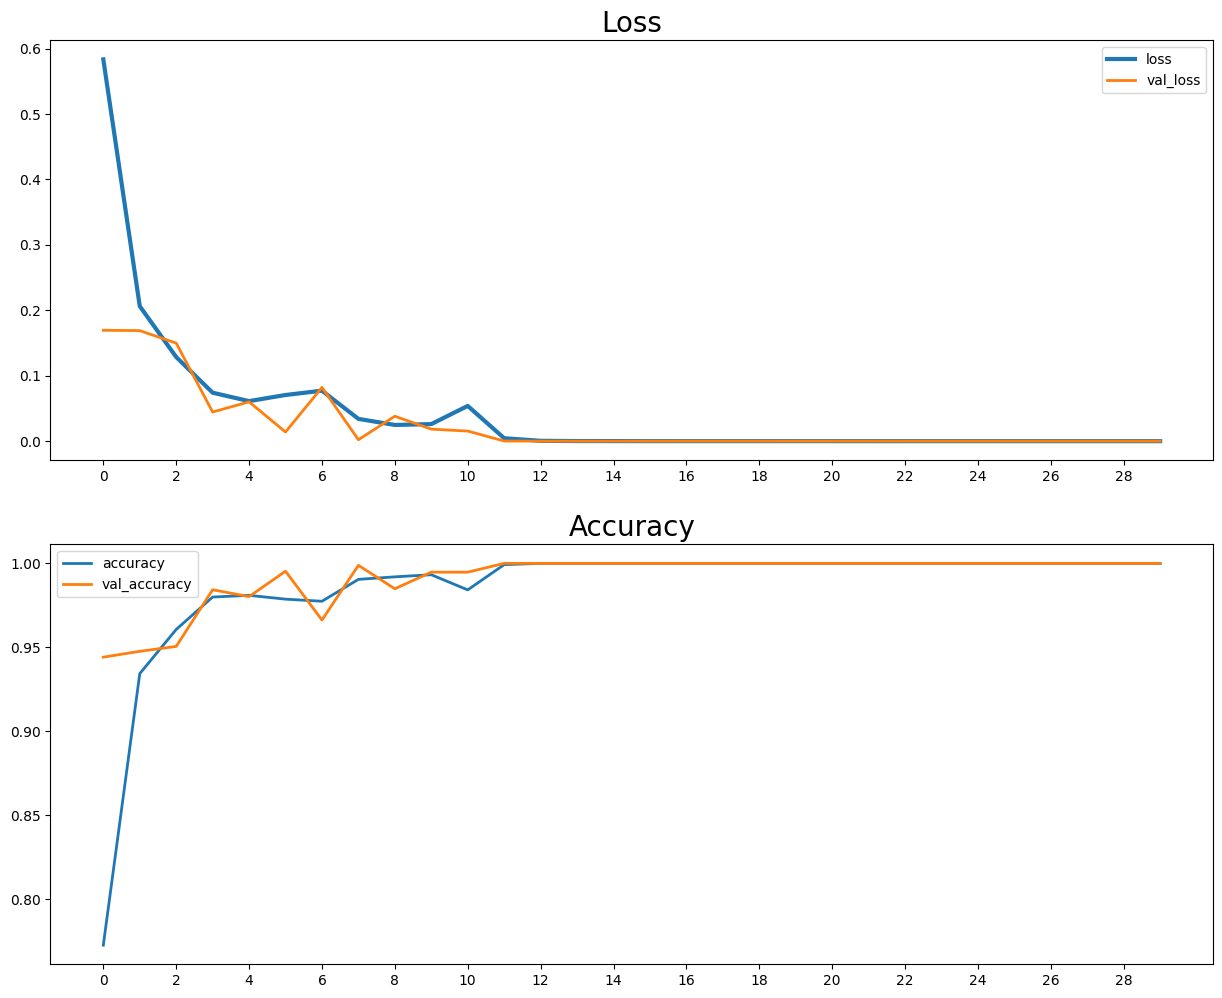

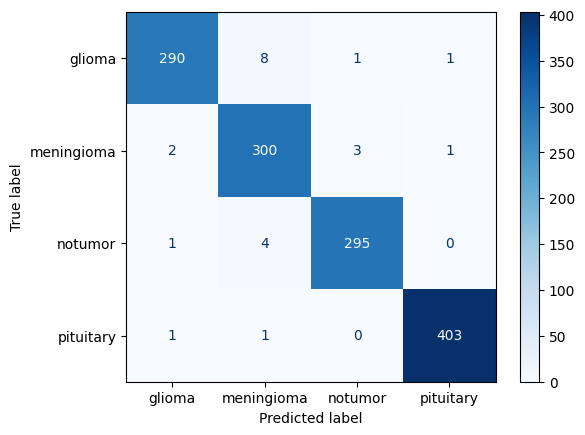

Classification Report
              precision    recall  f1-score   support

           0    0.98639   0.96667   0.97643       300
           1    0.95847   0.98039   0.96931       306
           2    0.98662   0.98333   0.98497       300
           3    0.99506   0.99506   0.99506       405

    accuracy                        0.98246      1311
   macro avg    0.98164   0.98136   0.98144      1311
weighted avg    0.98261   0.98246   0.98248      1311



In [34]:
best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
            model_name_1, std_m_tf25, history_std_m_tf25, training_time_1,
             model_name_2, std_m_tl25, history_std_m_tl25, training_time_2,
             model_name_3, std_m_nt, history_std_m_nt, training_time_3,
             test_ds_480, 'EfficientNetV2M Without Agumentation'
)

In [35]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.053577   
2  EfficientnetV2M Without Augmentation Trainable...   0.122906   

   Test Accuracy  Test F1Score  Training Time  
0       0.985507      0.972536     284.886228  
1       0.992372      0.987055     818.727502  
2       0.982456      0.969305    4399.008303  


## Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomTranslation(0.15, 0.15),
    # tf.keras.layers.RandomZoom(0.2, 0.2),
    # tf.keras.layers.RandomBrightness(0.2)
])

In [20]:
def augmentation_train(image, label):
    image = preprocess_input(image)
    image = data_augmentation(image)
    return image, label

def preprocess_val(image, label):
    image = preprocess_input(image)
    return image, label

In [21]:
train_aug_224 = train_ds_224.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_224 = valid_ds_224.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_224 = train_aug_224.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_224 = valid_aug_224.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
train_aug_300 = train_ds_300.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_300 = valid_ds_300.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_300 = train_aug_300.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_300 = valid_aug_300.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
train_aug_480 = train_ds_480.map(augmentation_train, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug_480 = valid_ds_480.map(preprocess_val, num_parallel_calls=tf.data.AUTOTUNE)

train_aug_480 = train_aug_480.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_aug_480 = valid_aug_480.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
train_aug_224 = train_aug_224.concatenate(train_ds_224)
train_aug_300 = train_aug_300.concatenate(train_ds_300)
train_aug_480 = train_aug_480.concatenate(train_ds_480)

### EfficientNetV2B0

#### trainable first25

In [45]:
model_name_1 = 'EfficientnetV2B0 With Augmentation Trainable First 25% Layer'
input_shape = (224,224,3)

aug_b0_tf25 = build_model_trainable_first25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tf25, history_aug_b0_tf25, training_time_1 = train(aug_b0_tf25, model_name_1, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 12:46:28.353141: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - ETA: 0s - loss: 0.3324 - accuracy: 0.8766 - f1_score: 0.8741

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 63s 61ms/step - loss: 0.3324 - accuracy: 0.8766 - f1_score: 0.8741 - val_loss: 0.0601 - val_accuracy: 0.9774 - val_f1_score: 0.9768 - lr: 1.0000e-04
Epoch 2/30
500/500 [==============================] - 30s 59ms/step - loss: 0.0706 - accuracy: 0.9773 - f1_score: 0.9768 - val_loss: 0.0190 - val_accuracy: 0.9948 - val_f1_score: 0.9949 - lr: 1.0000e-04
Epoch 3/30
500/500 [==============================] - 30s 60ms/step - loss: 0.0325 - accuracy: 0.9895 - f1_score: 0.9893 - val_loss: 2.5924e-04 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - lr: 1.0000e-04
Epoch 4/30
500/500 [==============================] - 29s 58ms/step - loss: 0.0231 - accuracy: 0.9924 - f1_score: 0.9922 - val_loss: 0.0305 - val_accuracy: 0.9919 - val_f1_score: 0.9919 - lr: 1.0000e-04
Epoch 5/30
500/500 [==============================] - 30s 60ms/step - loss: 0.0184 - accuracy: 0.9936 - f1_score: 0.9934 - val_loss: 1.3692e-04 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - lr:

#### trainable last25

In [46]:
model_name_2 = 'EfficientnetV2B0 With Augmentation Trainable Last 25% Layer'
input_shape = (224,224,3)

aug_b0_tl25 = build_model_trainable_last25(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_tl25, history_aug_b0_tl25, training_time_2 = train(aug_b0_tl25, model_name_2, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 13:01:30.898742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 27s 30ms/step - loss: 0.3538 - accuracy: 0.8597 - f1_score: 0.8566 - val_loss: 0.0825 - val_accuracy: 0.9676 - val_f1_score: 0.9669 - lr: 1.0000e-04
Epoch 2/30
500/500 [==============================] - 14s 28ms/step - loss: 0.0847 - accuracy: 0.9702 - f1_score: 0.9694 - val_loss: 0.0092 - val_accuracy: 0.9971 - val_f1_score: 0.9971 - lr: 1.0000e-04
Epoch 3/30
500/500 [==============================] - 14s 28ms/step - loss: 0.0415 - accuracy: 0.9854 - f1_score: 0.9851 - val_loss: 0.0016 - val_accuracy: 0.9994 - val_f1_score: 0.9994 - lr: 1.0000e-04
Epoch 4/30
500/500 [==============================] - 13s 26ms/step - loss: 0.0240 - accuracy: 0.9920 - f1_score: 0.9918 - val_loss: 0.0090 - val_accuracy: 0.9965 - val_f1_score: 0.9965 - lr: 1.0000e-04
Epoch 5/30
500/500 [==============================] - 14s 27ms/step - loss: 0.0220 - accuracy: 0.9933 - f1_score: 0.9931 - val_loss: 3.8625e-04 - val_accuracy: 1.0000 - val_f1_score: 1.0000 - lr: 1.0

#### not trainable

In [47]:
model_name_3 = 'EfficientnetV2B0 With Augmentation Not Trainable'
input_shape = (224,224,3)

aug_b0_nt = build_model_not_trainable(EfficientNetV2B0, input_shape=input_shape, num_classes=4)
aug_b0_nt, history_aug_b0_nt, training_time_3 = train(aug_b0_nt, model_name_3, train_aug_224, valid_aug_224, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30
500/500 [==============================] - 17s 25ms/step - loss: 0.6752 - accuracy: 0.7366 - f1_score: 0.7289 - val_loss: 0.3328 - val_accuracy: 0.8819 - val_f1_score: 0.8772 - lr: 1.0000e-04
Epoch 2/30
500/500 [==============================] - 12s 23ms/step - loss: 0.3947 - accuracy: 0.8556 - f1_score: 0.8508 - val_loss: 0.2483 - val_accuracy: 0.9115 - val_f1_score: 0.9084 - lr: 1.0000e-04
Epoch 3/30
500/500 [==============================] - 11s 22ms/step - loss: 0.3206 - accuracy: 0.8827 - f1_score: 0.8792 - val_loss: 0.1975 - val_accuracy: 0.9329 - val_f1_score: 0.9317 - lr: 1.0000e-04
Epoch 4/30
500/500 [==============================] - 11s 22ms/step - loss: 0.2758 - accuracy: 0.8991 - f1_score: 0.8964 - val_loss: 0.1630 - val_accuracy: 0.9433 - val_f1_score: 0.9422 - lr: 1.0000e-04
Epoch 5/30
500/500 [==============================] - 11s 23ms/step - loss: 0.2460 - accuracy: 0.9111 - f1_score: 0.9086 - val_loss: 0.1393 - val_accuracy: 0.9491 - val_f1_score: 0.9482 - 

Model comparison table saved to EfficientNetV2B0 With Agumentation
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2B0 With Augmentation Trainable F...  3.016747e-07       1.0   
1  EfficientnetV2B0 With Augmentation Trainable L...  5.597084e-07       1.0   
2   EfficientnetV2B0 With Augmentation Not Trainable  3.301142e-03       1.0   

   F1 Score  Training Time  
0       1.0     905.791257  
1       1.0     431.722249  
2       1.0     342.266896  
1/1 [==============================] - 1s 1s/step


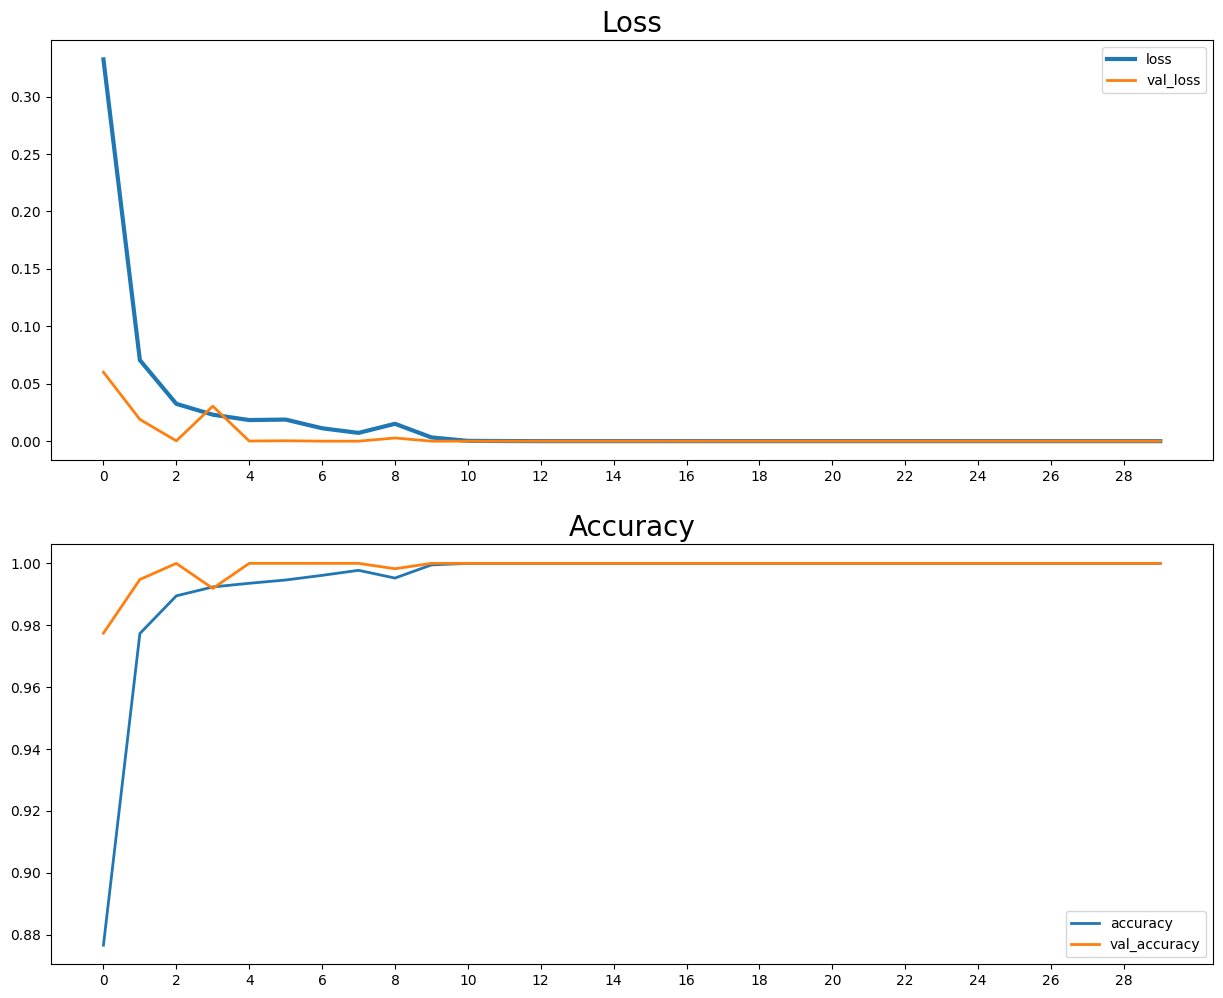

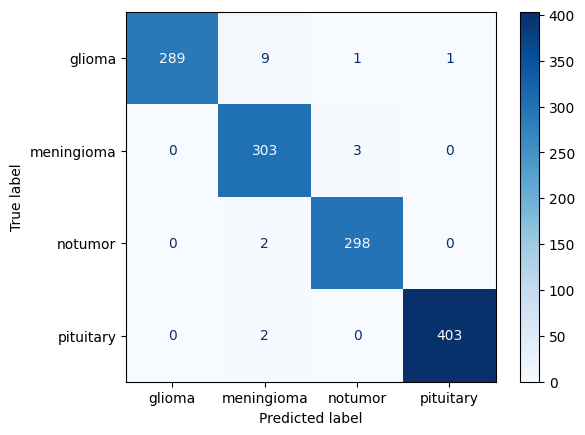

Classification Report
              precision    recall  f1-score   support

           0    1.00000   0.96333   0.98132       300
           1    0.95886   0.99020   0.97428       306
           2    0.98675   0.99333   0.99003       300
           3    0.99752   0.99506   0.99629       405

    accuracy                        0.98627      1311
   macro avg    0.98579   0.98548   0.98548      1311
weighted avg    0.98660   0.98627   0.98630      1311



In [48]:
best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
            model_name_1, aug_b0_tf25, history_aug_b0_tf25, training_time_1,
             model_name_2, aug_b0_tl25, history_aug_b0_tl25, training_time_2,
             model_name_3, aug_b0_nt, history_aug_b0_nt, training_time_3,
             test_ds_224, 'EfficientNetV2B0 With Agumentation'
)

In [49]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)


Results saved to results/result.csv
Result Dictionary Table:
                                          Model Name  Test Loss  \
0  EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   
1  EfficientnetV2B3 Without Augmentation Trainabl...   0.053577   
2  EfficientnetV2M Without Augmentation Trainable...   0.122906   
3  EfficientnetV2B0 With Augmentation Trainable F...   0.133764   

   Test Accuracy  Test F1Score  Training Time  
0       0.985507      0.972536     284.886228  
1       0.992372      0.987055     818.727502  
2       0.982456      0.969305    4399.008303  
3       0.986270      0.974276     905.791257  


### EfficientNetV2B3

#### trainable first25

In [23]:
result_dict = load_results_from_csv(file_path='results/result.csv')
result_dict

{'Model Name': ['EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2M Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2M Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 With Augmentation Trainable First 25% Layer'],
 'Test Loss': [0.092372789978981,
  0.092372789978981,
  0.0535766929388046,
  0.092372789978981,
  0.0535766929388046,
  0.1229058876633644,
  0.092372789978981,
  0.0535766929388046,
  0.1229058876633644,
  0.1337643712759018],
 'Test Accuracy': [0.9855072498321532,
  0.9855072498321532,
  0.992372214

In [31]:
model_name_1 = 'EfficientnetV2B3 With Augmentation Trainable First 25% Layer'
input_shape = (300,300,3)

aug_b3_tf25 = build_model_trainable_first25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tf25, history_aug_b3_tf25, training_time_1 = train(aug_b3_tf25, model_name_1, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 13:23:53.997403: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-17 13:24:04.531397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-11-17 13:24:04.877981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-17 13:24:05.211483: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1cbc69b150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-17 13:24:05.211526: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2024-11-17 13:24:05.247702: I tensorflow/compiler/mlir/tensorflow/utils/dum

498/498 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8507 - f1_score: 0.8483

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


498/498 [==============================] - 106s 108ms/step - loss: 0.4069 - accuracy: 0.8507 - f1_score: 0.8483 - val_loss: 0.1031 - val_accuracy: 0.9653 - val_f1_score: 0.9649 - lr: 1.0000e-04
Epoch 2/30
498/498 [==============================] - 52s 104ms/step - loss: 0.1361 - accuracy: 0.9572 - f1_score: 0.9565 - val_loss: 0.0382 - val_accuracy: 0.9838 - val_f1_score: 0.9836 - lr: 1.0000e-04
Epoch 3/30
498/498 [==============================] - 49s 99ms/step - loss: 0.0682 - accuracy: 0.9767 - f1_score: 0.9763 - val_loss: 0.0287 - val_accuracy: 0.9873 - val_f1_score: 0.9872 - lr: 1.0000e-04
Epoch 4/30
498/498 [==============================] - 49s 99ms/step - loss: 0.0455 - accuracy: 0.9852 - f1_score: 0.9848 - val_loss: 0.0075 - val_accuracy: 0.9965 - val_f1_score: 0.9965 - lr: 1.0000e-04
Epoch 5/30
498/498 [==============================] - 49s 98ms/step - loss: 0.0309 - accuracy: 0.9907 - f1_score: 0.9906 - val_loss: 0.0022 - val_accuracy: 0.9994 - val_f1_score: 0.9994 - lr: 1.00

#### trainable last25

In [32]:
model_name_2 = 'EfficientnetV2B3 With Augmentation Trainable Last 25% Layer'
input_shape = (300,300,3)

aug_b3_tl25 = build_model_trainable_last25(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_tl25, history_aug_b3_tl25, training_time_2 = train(aug_b3_tl25, model_name_2, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30


2024-11-17 13:49:05.229188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


498/498 [==============================] - 43s 51ms/step - loss: 0.4094 - accuracy: 0.8396 - f1_score: 0.8348 - val_loss: 0.0943 - val_accuracy: 0.9670 - val_f1_score: 0.9660 - lr: 1.0000e-04
Epoch 2/30
498/498 [==============================] - 23s 46ms/step - loss: 0.1324 - accuracy: 0.9526 - f1_score: 0.9512 - val_loss: 0.0429 - val_accuracy: 0.9850 - val_f1_score: 0.9847 - lr: 1.0000e-04
Epoch 3/30
498/498 [==============================] - 23s 47ms/step - loss: 0.0653 - accuracy: 0.9784 - f1_score: 0.9778 - val_loss: 0.0257 - val_accuracy: 0.9925 - val_f1_score: 0.9923 - lr: 1.0000e-04
Epoch 4/30
498/498 [==============================] - 23s 45ms/step - loss: 0.0335 - accuracy: 0.9888 - f1_score: 0.9885 - val_loss: 0.0108 - val_accuracy: 0.9959 - val_f1_score: 0.9959 - lr: 1.0000e-04
Epoch 5/30
498/498 [==============================] - 23s 47ms/step - loss: 0.0308 - accuracy: 0.9902 - f1_score: 0.9900 - val_loss: 0.0042 - val_accuracy: 0.9988 - val_f1_score: 0.9988 - lr: 1.0000e

#### not trainable

In [33]:
model_name_3 = 'EfficientnetV2B3 With Augmentation Not Trainable'
input_shape = (300,300,3)

aug_b3_nt = build_model_not_trainable(EfficientNetV2B3, input_shape=input_shape, num_classes=4)
aug_b3_nt, history_aug_b3_nt, training_time_3 = train(aug_b3_nt, model_name_3, train_aug_300, valid_aug_300, EPOCHS, SAVE_DIRECTORY)

Epoch 1/30
498/498 [==============================] - 28s 40ms/step - loss: 0.7597 - accuracy: 0.6999 - f1_score: 0.6913 - val_loss: 0.3633 - val_accuracy: 0.8623 - val_f1_score: 0.8568 - lr: 1.0000e-04
Epoch 2/30
498/498 [==============================] - 19s 38ms/step - loss: 0.4642 - accuracy: 0.8252 - f1_score: 0.8199 - val_loss: 0.2962 - val_accuracy: 0.8848 - val_f1_score: 0.8803 - lr: 1.0000e-04
Epoch 3/30
498/498 [==============================] - 18s 37ms/step - loss: 0.3933 - accuracy: 0.8563 - f1_score: 0.8527 - val_loss: 0.2513 - val_accuracy: 0.9086 - val_f1_score: 0.9071 - lr: 1.0000e-04
Epoch 4/30
498/498 [==============================] - 19s 38ms/step - loss: 0.3523 - accuracy: 0.8730 - f1_score: 0.8698 - val_loss: 0.2245 - val_accuracy: 0.9201 - val_f1_score: 0.9187 - lr: 1.0000e-04
Epoch 5/30
498/498 [==============================] - 18s 36ms/step - loss: 0.3203 - accuracy: 0.8800 - f1_score: 0.8769 - val_loss: 0.2054 - val_accuracy: 0.9242 - val_f1_score: 0.9236 - 

Model comparison table saved to EfficientNetV2B3 With Agumentation
Model Comparison Table:
                                          Model Name          Loss  Accuracy  \
0  EfficientnetV2B3 With Augmentation Trainable F...  1.309685e-06  1.000000   
1  EfficientnetV2B3 With Augmentation Trainable L...  7.010301e-07  1.000000   
2   EfficientnetV2B3 With Augmentation Not Trainable  1.958742e-02  0.996528   

   F1 Score  Training Time  
0  1.000000    1513.573711  
1  1.000000     692.732636  
2  0.996528     553.774162  
1/1 [==============================] - 0s 233ms/step


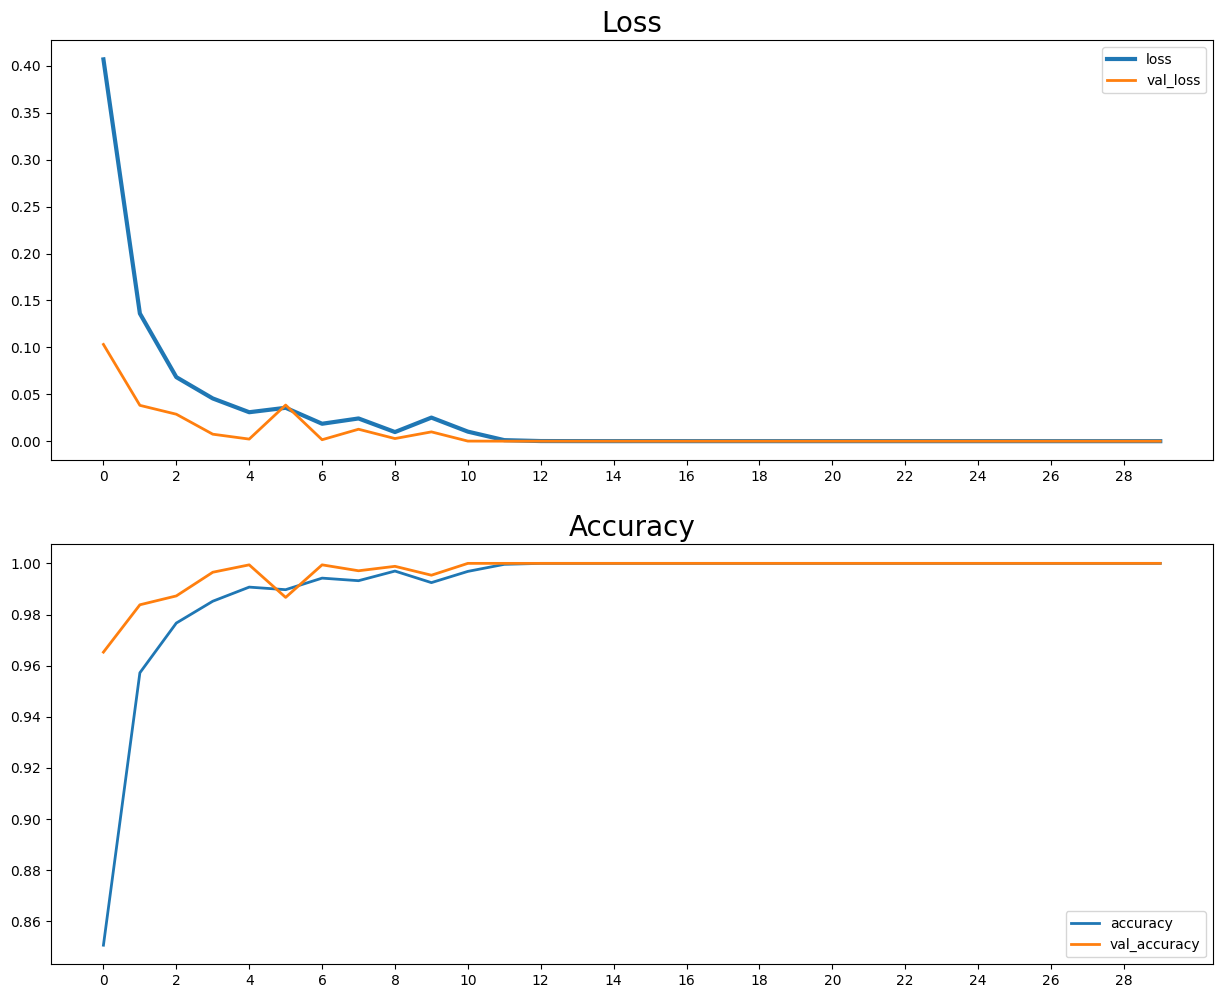

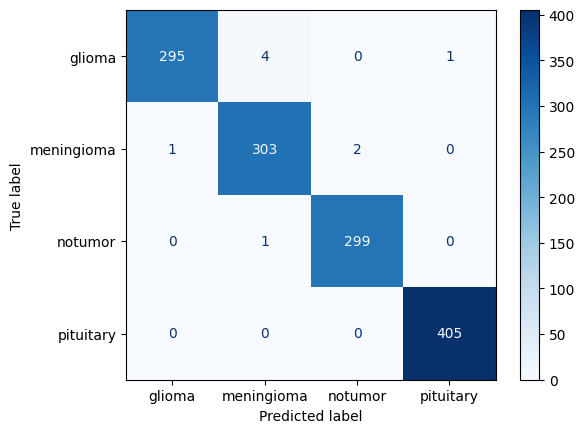

Classification Report
              precision    recall  f1-score   support

           0    0.99662   0.98333   0.98993       300
           1    0.98377   0.99020   0.98697       306
           2    0.99336   0.99667   0.99501       300
           3    0.99754   1.00000   0.99877       405

    accuracy                        0.99314      1311
   macro avg    0.99282   0.99255   0.99267      1311
weighted avg    0.99316   0.99314   0.99313      1311



In [34]:
best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
            model_name_1, aug_b3_tf25, history_aug_b3_tf25, training_time_1,
             model_name_2, aug_b3_tl25, history_aug_b3_tl25, training_time_2,
             model_name_3, aug_b3_nt, history_aug_b3_nt, training_time_3,
             test_ds_300, 'EfficientNetV2B3 With Agumentation'
)

In [35]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

Results saved to results/result.csv
Result Dictionary Table:
                                           Model Name  Test Loss  \
0   EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   
1   EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   
2   EfficientnetV2B3 Without Augmentation Trainabl...   0.053577   
3   EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   
4   EfficientnetV2B3 Without Augmentation Trainabl...   0.053577   
5   EfficientnetV2M Without Augmentation Trainable...   0.122906   
6   EfficientnetV2B0 Without Augmentation Trainabl...   0.092373   
7   EfficientnetV2B3 Without Augmentation Trainabl...   0.053577   
8   EfficientnetV2M Without Augmentation Trainable...   0.122906   
9   EfficientnetV2B0 With Augmentation Trainable F...   0.133764   
10  EfficientnetV2B3 With Augmentation Trainable F...   0.061761   

    Test Accuracy  Test F1Score  Training Time  
0        0.985507      0.972536     284.886228  
1        0.985507      0

### EfficientNetV2M

In [25]:
result_dict = load_results_from_csv(file_path='results/result.csv')
result_dict

{'Model Name': ['EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2M Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2M Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 With Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augmentation Trainable First 25% Layer',
  'EfficientnetV2B0 Without Augmentation Trainable First 25 Layer',
  'EfficientnetV2B3 Without Augm

In [26]:
EPOCHS = 15

In [27]:
model_name_1 = 'EfficientnetV2M With Augmentation Trainable First 25% Layer'
input_shape = (480,480,3)

aug_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)

In [28]:
aug_m_tf25.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 efficientnetv2-m (Function  (None, 15, 15, 1280)      53150388  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 1280)      0         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936

#### trainable first25

In [ ]:
model_name_1 = 'EfficientnetV2M With Augmentation Trainable First 25% Layer'
input_shape = (480,480,3)

aug_m_tf25 = build_model_trainable_first25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tf25, history_aug_m_tf25, training_time_1 = train(aug_m_tf25, model_name_1, train_aug_480, valid_aug_480, EPOCHS, SAVE_DIRECTORY)

Epoch 1/15


2024-11-19 15:43:27.261143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-19 15:43:40.023482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-11-19 15:43:41.466940: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-19 15:43:41.763806: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56164a91dbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-19 15:43:41.763851: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 3g.20gb, Compute Capability 8.0
2024-11-19 15:43:41.799866: I tensorflow/compiler/mlir/tensorflow/utils/dum

3998/3998 [==============================] - ETA: 0s - loss: 1455.8118 - accuracy: 0.2845 - f1_score: 0.2815

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3998/3998 [==============================] - 491s 102ms/step - loss: 1455.8118 - accuracy: 0.2845 - f1_score: 0.2815 - val_loss: 1.3532 - val_accuracy: 0.2573 - val_f1_score: 0.1024 - lr: 1.0000e-04
Epoch 2/15
3998/3998 [==============================] - 403s 101ms/step - loss: 1.4247 - accuracy: 0.3063 - f1_score: 0.2964 - val_loss: 1.1387 - val_accuracy: 0.4364 - val_f1_score: 0.3366 - lr: 1.0000e-04
Epoch 3/15
2574/3998 [==================>...........] - ETA: 11:55 - loss: 1.2352 - accuracy: 0.3990 - f1_score: 0.3928

#### trainable last25

In [ ]:
model_name_2 = 'EfficientnetV2M With Augmentation Trainable Last 25% Layer'
input_shape = (480,380,3)

aug_m_tl25 = build_model_trainable_last25(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_tl25, history_aug_m_tl25, training_time_2 = train(aug_m_tl25, model_name_2, train_aug_380, valid_aug_480, EPOCHS, SAVE_DIRECTORY)

#### not trainable

In [ ]:
model_name_3 = 'EfficientnetV2M With Augmentation Not Trainable'
input_shape = (480,480,3)

aug_m_nt = build_model_not_trainable(EfficientNetV2M, input_shape=input_shape, num_classes=4)
aug_m_nt, history_aug_m_nt, training_time_3 = train(aug_m_nt, model_name_3, train_aug_480, valid_aug_480, EPOCHS, SAVE_DIRECTORY)

In [ ]:
best_model_name, test_loss, test_acc, test_f1score, best_time = best_variant(
            model_name_1, aug_m_tf25, history_aug_m_tf25, training_time_1,
             model_name_2, aug_m_tl25, history_aug_m_tl25, training_time_2,
             model_name_3, aug_m_nt, history_aug_m_nt, training_time_3,
             test_ds_480, 'EfficientNetV2BM With Agumentation')

In [ ]:
result(best_model_name, test_loss, test_acc, test_f1score, result_dict, best_time)

# Convert result_dict to a DataFrame
df = pd.DataFrame(result_dict)

# Convert any TensorFlow tensors in the F1Score column to numpy for better readability
df['Test F1Score'] = df['Test F1Score'].apply(lambda x: x.numpy() if hasattr(x, 'numpy') else x)

# Print the DataFrame as a table
print("Result Dictionary Table:")
print(df)

# Result

In [ ]:
results = pd.DataFrame(result_dict)

print(results)

In [ ]:
results.to_csv("result.csv", index=False)

df = pd.read_csv("result.csv")

print(df)

# Try

In [67]:
def build_model(base_model, train_ds, valid_ds, input_shape, num_classes):
    input = tf.keras.layers.Input(shape=input_shape)
    
    base_model = base_model(input_shape=input_shape, include_top=False, classes=num_classes, weights='imagenet')
    base_model.trainable = False


    x = base_model(input, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)               
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    output = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=input, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    # checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(saving_path, monitor='val_accuracy', save_best_only=True)

    # Early Stoping Call-Backc to stop trainig process after 'patience' epochs if the metric doesn't grow
    earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

    # ReduceLROnPlateau Call-Back to decrease learning-rate base on 'monitor' parameter after 'patience' epochs with a 'factor' is doesn't improve
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Model training
    history = model.fit(
        train_ds,
        epochs=20,
        callbacks=[earlystop_cb, reduce_lr],
        validation_data=valid_ds
    )




    # Fine Tuning

    base_model.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy', F1Score()]
    )

    history = model.fit(
        train_ds,
        epochs=15,
        callbacks=[earlystop_cb, reduce_lr],
        validation_data=valid_ds
    )




    # Results

    # Convert result of training to DataFrame
    result = pd.DataFrame(history.history)

    # Define a X variable to store range of epochs
    x = np.arange(len(result))

    # Create a plot with 3 row and 1 col with size of (15, 12)
    fig, ax = plt.subplots(2, 1, figsize=(15, 12))

    # AX0 : Loss
    ax[0].plot(x, result.loss, label='loss', linewidth=3)
    ax[0].plot(x, result.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
    ax[0].set_title('Loss', fontsize=20)
    ax[0].set_xticks(np.arange(0, len(x), 2))
    ax[0].legend()

    #  AX1 : Loss
    ax[1].plot(x, result.accuracy, label='accuracy', linewidth=2)
    ax[1].plot(x, result.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
    ax[1].set_title('Accuracy', fontsize=20)
    ax[1].set_xticks(np.arange(0, len(x), 2))
    ax[1].legend()


    # Evaluate model
    test_loss, test_acc, test_f1score = model.evaluate(test_ds_224, verbose=1)


    # Confusion Matrix
    # Get the class names from the dataset
    class_names = sorted(classes)

    # Make predictions
    y_pred = []
    y_true = []

    for images, labels in test_ds_224:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = np.argmax(labels, axis=1)
        y_true.extend(labels)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.show()

    print('Classification Report')
    cr = classification_report(y_true, y_pred, digits=5)
    print(cr)

    return model, history, test_loss, test_acc, test_f1score

Epoch 1/20
125/125 [==============================] - 11s 41ms/step - loss: 0.5516 - accuracy: 0.7797 - f1_score: 0.7723 - val_loss: 0.3370 - val_accuracy: 0.8686 - val_f1_score: 0.8656 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 4s 30ms/step - loss: 0.3449 - accuracy: 0.8715 - f1_score: 0.8677 - val_loss: 0.2391 - val_accuracy: 0.9089 - val_f1_score: 0.9037 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 4s 30ms/step - loss: 0.2944 - accuracy: 0.8915 - f1_score: 0.8886 - val_loss: 0.2138 - val_accuracy: 0.9194 - val_f1_score: 0.9161 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 4s 29ms/step - loss: 0.2511 - accuracy: 0.9030 - f1_score: 0.8999 - val_loss: 0.2144 - val_accuracy: 0.9182 - val_f1_score: 0.9141 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 4s 30ms/step - loss: 0.2261 - accuracy: 0.9112 - f1_score: 0.9081 - val_loss: 0.2002 - val_accuracy: 0.9229 - val_f1_score: 0.9168 - lr: 0.0010
Epoch 6/2

2024-10-27 16:30:48.694599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_27/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


125/125 [==============================] - 42s 81ms/step - loss: 0.0491 - accuracy: 0.9845 - f1_score: 0.9839 - val_loss: 0.1328 - val_accuracy: 0.9609 - val_f1_score: 0.9585 - lr: 1.0000e-05
Epoch 2/15
125/125 [==============================] - 10s 83ms/step - loss: 0.0438 - accuracy: 0.9855 - f1_score: 0.9851 - val_loss: 0.1226 - val_accuracy: 0.9632 - val_f1_score: 0.9611 - lr: 1.0000e-05
Epoch 3/15
125/125 [==============================] - 10s 82ms/step - loss: 0.0415 - accuracy: 0.9840 - f1_score: 0.9835 - val_loss: 0.1187 - val_accuracy: 0.9614 - val_f1_score: 0.9594 - lr: 1.0000e-05
Epoch 4/15
125/125 [==============================] - 10s 83ms/step - loss: 0.0276 - accuracy: 0.9905 - f1_score: 0.9902 - val_loss: 0.1117 - val_accuracy: 0.9679 - val_f1_score: 0.9660 - lr: 1.0000e-05
Epoch 5/15
125/125 [==============================] - 10s 82ms/step - loss: 0.0295 - accuracy: 0.9912 - f1_score: 0.9909 - val_loss: 0.1163 - val_accuracy: 0.9702 - val_f1_score: 0.9680 - lr: 1.0000e

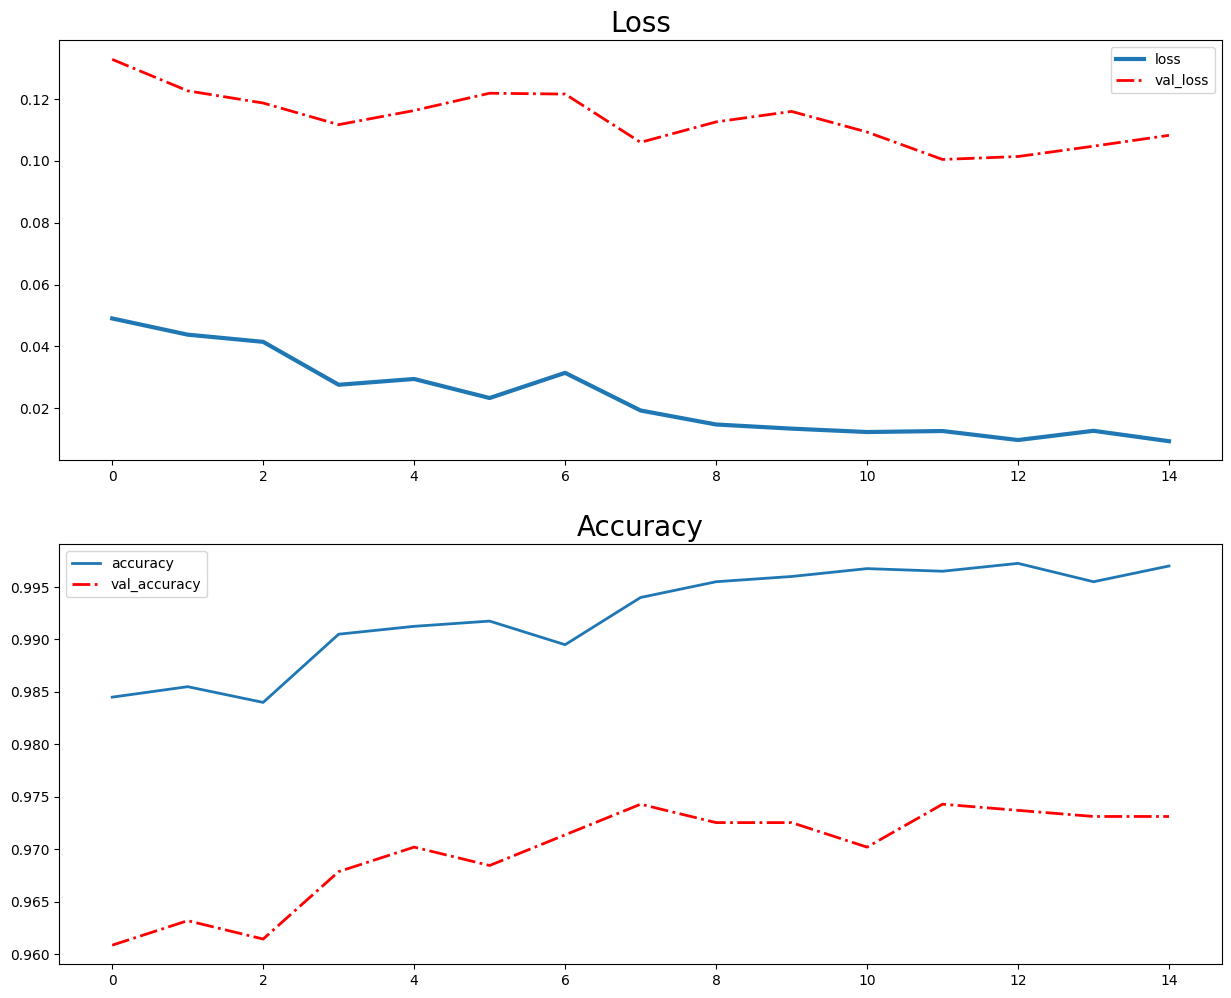

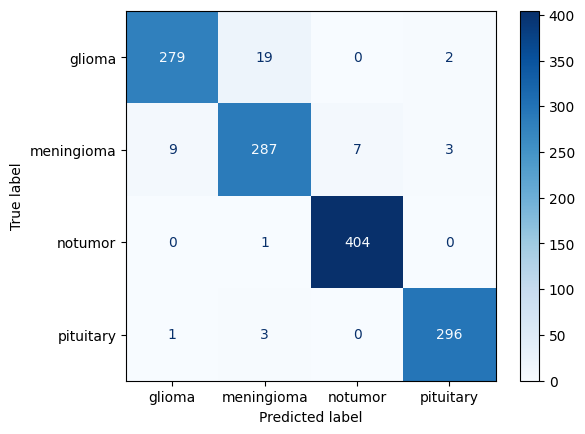

Classification Report
              precision    recall  f1-score   support

           0    0.96540   0.93000   0.94737       300
           1    0.92581   0.93791   0.93182       306
           2    0.98297   0.99753   0.99020       405
           3    0.98339   0.98667   0.98502       300

    accuracy                        0.96568      1311
   macro avg    0.96439   0.96303   0.96360      1311
weighted avg    0.96570   0.96568   0.96559      1311



In [68]:
model_name = 'test'
input_shape = (224,224,3)

model = build_model(EfficientNetV2B0, train_ds_224, valid_ds_224, input_shape=input_shape, num_classes=4)